# Explore Sound Visualization of Low Amplitude Ranges

Earl F Glynn

2017-12-10

# Purpose

Explore 

 * What is "silence"?  
  
 * How do spectrograms change when the amplitude range changes?
 
 * Is there an amplitude range below which wav files can be deemed to be "silence."

Based on [Sound-Visualization notebook](https://github.com/EarlGlynn/kaggle-speech-recognition/tree/master/Jupyter/01-Sound-WAV-visualization), which was adapted from Kaggle [Data visualization and investigation](https://www.kaggle.com/davids1992/data-visualization-and-investigation) by *DavisS*.

Find files of given amplitude min, max, range in the train/test WAV-File-Inventory files from [this Kaggle discussion thread](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/44687).

# Setup

In [1]:
import pandas as pd

Math

In [2]:
import librosa
import numpy    as np

from scipy.fftpack         import fft
from scipy                 import signal
from scipy.io              import wavfile

Visualization

In [3]:
import matplotlib.pyplot as plt
import pandas            as pd

import IPython.display   as ipd
import librosa.display

import plotly.offline    as py

py.init_notebook_mode(connected=True)

%matplotlib inline

Location of train/test audio files

In [4]:
trainAudioPath = '../../input/train/audio/'

## Helper Functions

[Format output of code cell with Markdown](https://stackoverflow.com/questions/32026727/format-output-of-code-cell-with-markdown)

In [5]:
from IPython.display import Markdown, display
def printMarkdown(string):
    display(Markdown(string))

Raw Wave File

In [6]:
def plotRawWave(plotTitle, sampleRate, samples, figWidth=14, figHeight=4):
    plt.figure(figsize=(figWidth, figHeight))
    plt.plot(np.linspace(0, sampleRate/len(samples), sampleRate), samples)
    plt.title("Raw sound wave of " + plotTitle)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [sec]")
    plt.show()  # force display while in for loop
    return None

Spectrogram

In [7]:
def computeLogSpectrogram(audio, sampleRate, windowSize=20, stepSize=10, epsilon=1e-10):
    nperseg  = int(round(windowSize * sampleRate / 1000))
    noverlap = int(round(stepSize   * sampleRate / 1000))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sampleRate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + epsilon)

In [8]:
def plotLogSpectrogram(plotTitle, freqs, times, spectrogram, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               cmap="inferno",   #  default was "viridis"  (perceptually uniform)
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(pad=0.01)
    plt.title('Spectrogram of ' + plotTitle)
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    fig.tight_layout()
    plt.show()  # force display while in for loop
    return None

Mel Spectrogram

In [9]:
def computeLogMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples, sr=sampleRate, n_mels=nMels)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    
    return logMelSpectrogram

In [10]:
def plotLogMelSpectrogram(plotTitle, sampleRate, logMelSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(logMelSpectrum, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.title('Mel log-frequency power spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()  
    plt.show()  # force display while in for loop
    return None

Compute and plot MFCC

In [11]:
def computeMFCC(samples, sampleRate, nFFT=512, hopLength=256, nMFCC=40):
    mfcc = librosa.feature.mfcc(y=samples, sr=sampleRate, 
                                n_fft=nFFT, hop_length=hopLength, n_mfcc=nMFCC)
    
    # Let's add on the first and second deltas  (what is this really doing?)
    #mfcc = librosa.feature.delta(mfcc, order=2)
    return mfcc

In [12]:
def plotMFCC(plotTitle, sampleRate, mfcc, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(mfcc, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.colorbar(pad=0.01)
    plt.title("Mel-frequency cepstral coefficients (MFCC): " + plotTitle)
    plt.tight_layout()
    plt.show()  # force display while in for loop
    return None

Plot waveform along with the above three spectrum alternatives

In [13]:
def showWavefile(filename):
    sampleRate, samples = wavfile.read(filename)  
    plotRawWave(filename, sampleRate, samples)
    
    freqs, times, logSpectrogram = computeLogSpectrogram(samples, sampleRate)
    plotLogSpectrogram(filename, freqs, times, logSpectrogram)
    
    logMelSpectrogram = computeLogMelSpectrogram(samples, sampleRate)
    plotLogMelSpectrogram(filename, sampleRate, logMelSpectrogram)
    
    mfcc = computeMFCC(samples, sampleRate)
    print(mfcc.shape)
    plotMFCC(filename, sampleRate, mfcc)
    
    return sampleRate, samples, logSpectrogram, logMelSpectrogram, mfcc

# Low Amplitude Waveforms

List files to explore in data structure .

In [14]:
labels = ['filename', 'comments']
waves  = [
          ('bird/3e7124ba_nohash_0.wav',  # 0
           'Complete silence heard at maximum volume. 3709 test files match this.'),
    
          ('zero/d90b4138_nohash_2.wav',  # 5
           'Complete silence heard at maximum volume.'),

          ('four/e96a5020_nohash_1.wav',  # 20
           'Two noise "blips" heard at maximum volume.'),

          ('zero/ced835d3_nohash_0.wav',  # 80
           'Unidentifiable noise heard at maximum volume.'),

          ('five/a6d586b7_nohash_0.wav',  # 128
           'Unintelligible sound heard at maximum volume.' ),
 
          ('seven/fd395b74_nohash_4.wav',  # 193
           'Noise with a "click" heard at full volume' ),  
    
          ('zero/3f2b358d_nohash_2.wav',  # 200
           'All noise at maximum volume.'),

          ('eight/fd395b74_nohash_0.wav',  # 256
           'Questionable "eight" identifiable but with a lot of noise at full volume.'),
                                                                                                    
          ('zero/fd395b74_nohash_0.wav',  # 385
           'Faint zero with a lot of noise.'),
    
          ('two/ec5ab5d5_nohash_2.wav',  # 511
           'Crisp "two" clearly heard at low or high volume. Waveform clearly shows high signal to noise.'),

           ('three/33f60c62_nohash_1.wav',  # 1024
           '"three" clear at medium to high volume levels, but with some "beeps".'),
                                                                                  
          ('zero/f638a812_nohash_0.wav',  # 65535
           'VERY LOUD.  Seems loud even at low volume level.  Note clipping in waveform.')
         ]                  

wavedf = pd.DataFrame.from_records(waves, columns=labels)
wavedf

,filename,comments
0,bird/3e7124ba_nohash_0.wav,Complete silence heard at maximum volume. 3709...
1,zero/d90b4138_nohash_2.wav,Complete silence heard at maximum volume.
2,four/e96a5020_nohash_1.wav,"Two noise ""blips"" heard at maximum volume."
3,zero/ced835d3_nohash_0.wav,Unidentifiable noise heard at maximum volume.
4,five/a6d586b7_nohash_0.wav,Unintelligible sound heard at maximum volume.
5,seven/fd395b74_nohash_4.wav,"Noise with a ""click"" heard at full volume"
6,zero/3f2b358d_nohash_2.wav,All noise at maximum volume.
7,eight/fd395b74_nohash_0.wav,"Questionable ""eight"" identifiable but with a l..."
8,zero/fd395b74_nohash_0.wav,Faint zero with a lot of noise.
9,two/ec5ab5d5_nohash_2.wav,"Crisp ""two"" clearly heard at low or high volum..."


# Display waveforms and related spectrograms

Need this trick below:  [More than one Audio object in a Jupyter Notebook cell](https://stackoverflow.com/questions/33048353/more-than-one-audio-object-in-a-jupyter-ipython-notebook-cell).

# "bird" [amplitude from 0 to 0, range = 0]

Complete silence heard at maximum volume. 3709 test files match this.


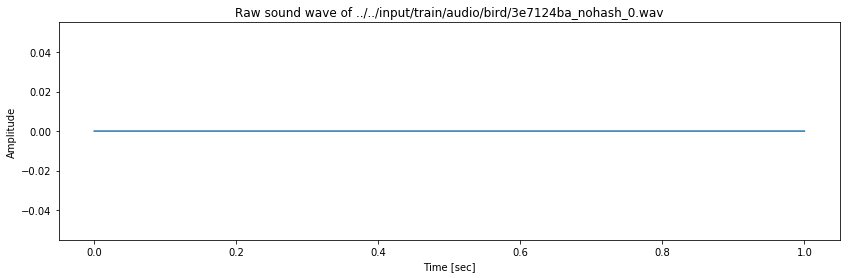

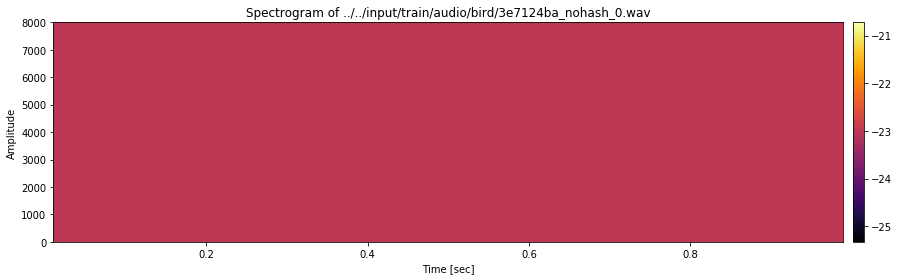

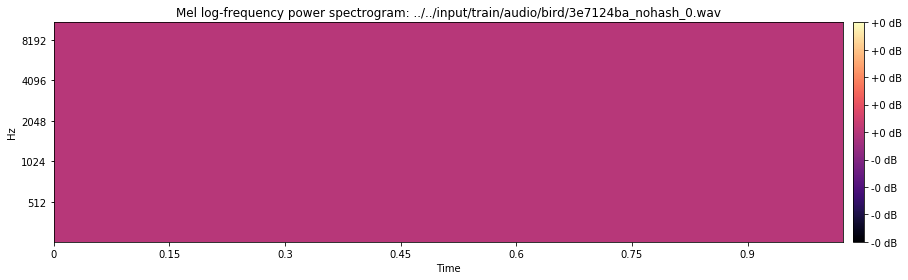

(40, 63)


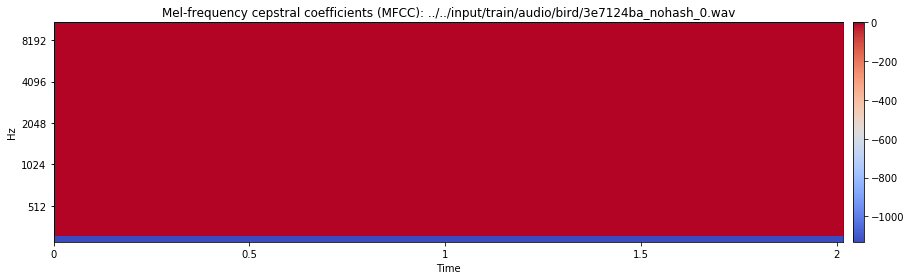

# "zero" [amplitude from -3 to 2, range = 5]

Complete silence heard at maximum volume.


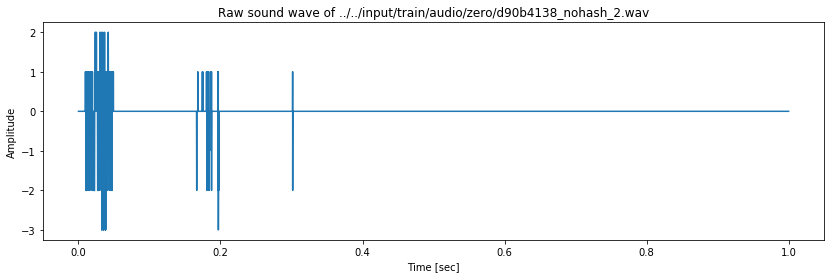

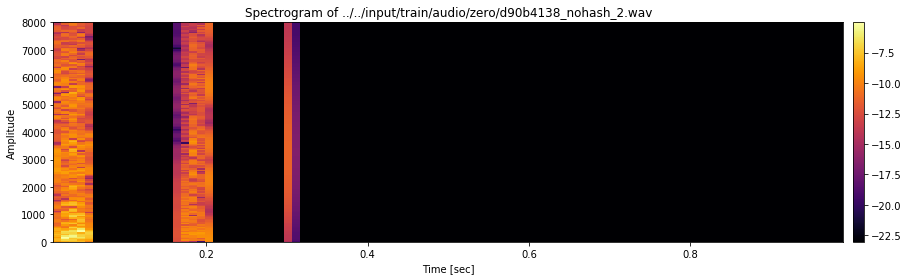

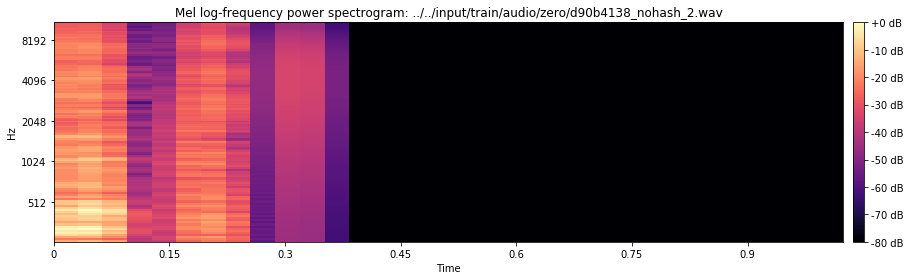

(40, 63)


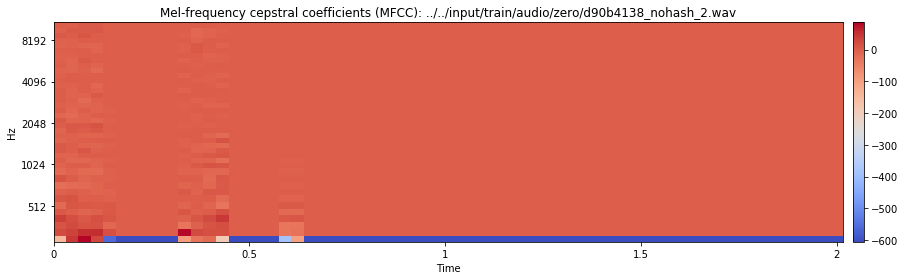

# "four" [amplitude from -11 to 9, range = 20]

Two noise "blips" heard at maximum volume.


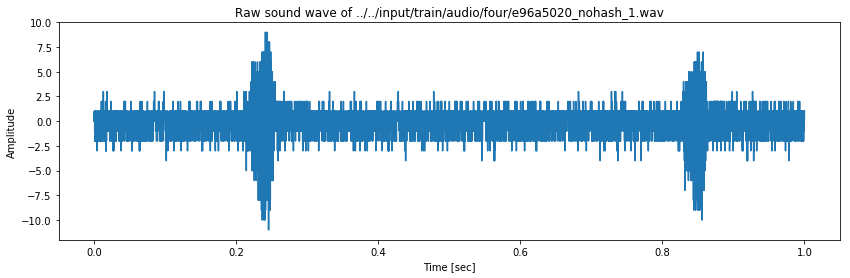

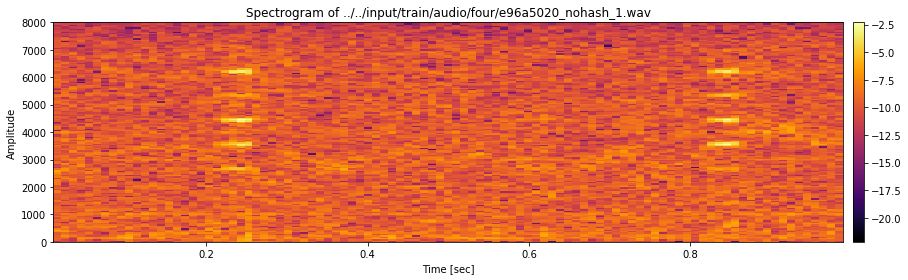

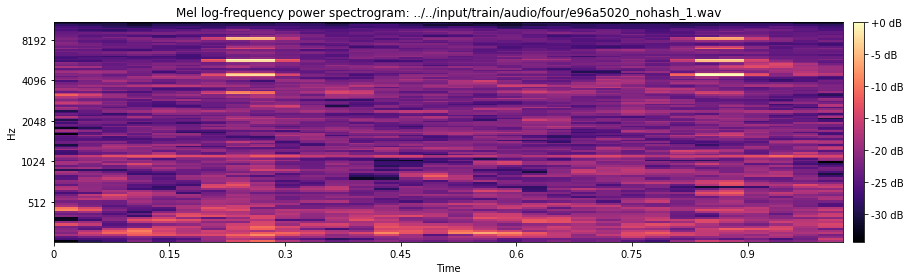

(40, 63)


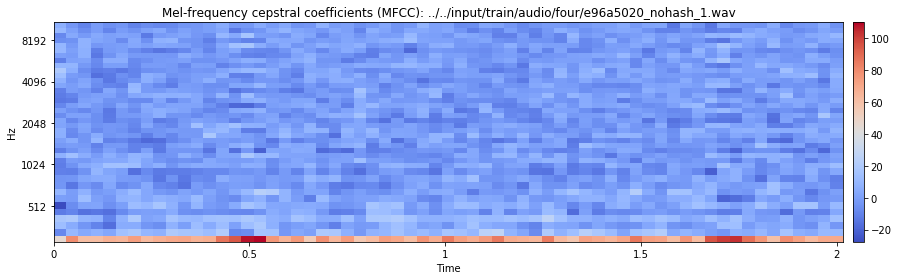

# "zero" [amplitude from -42 to 38, range = 80]

Unidentifiable noise heard at maximum volume.


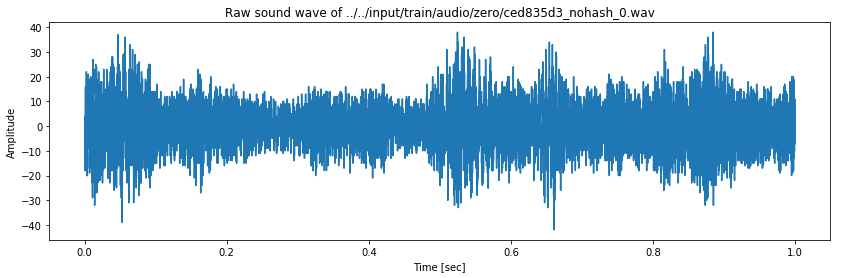

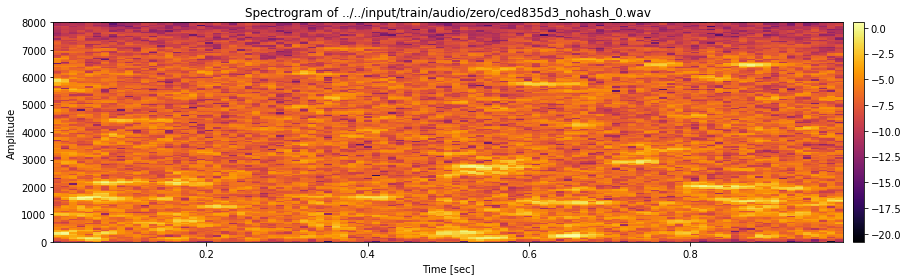

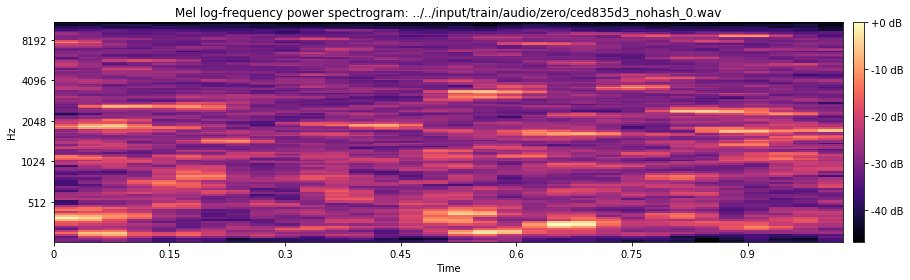

(40, 63)


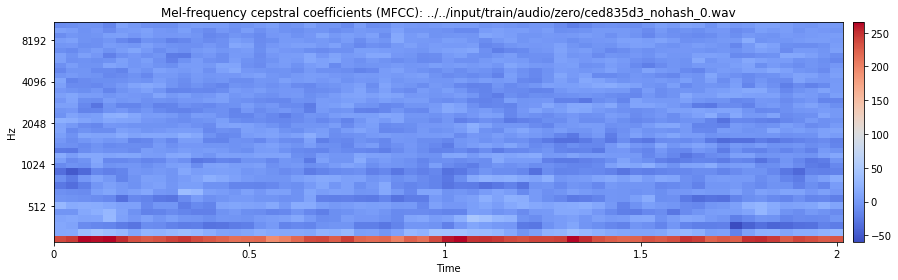

# "five" [amplitude from -61 to 67, range = 128]

Unintelligible sound heard at maximum volume.


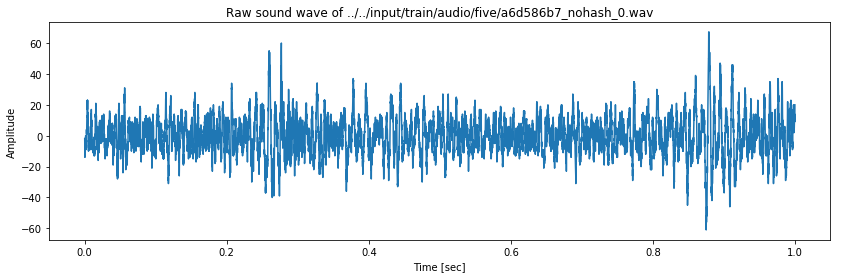

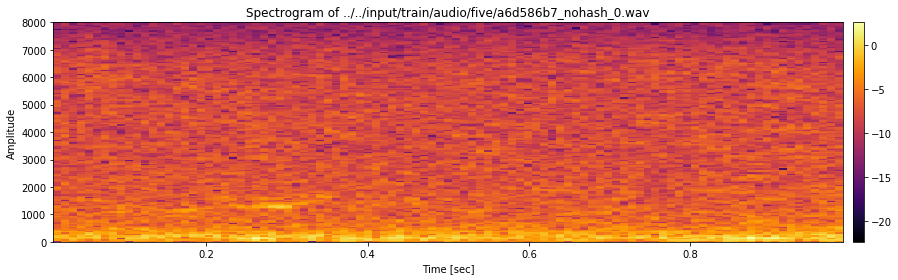

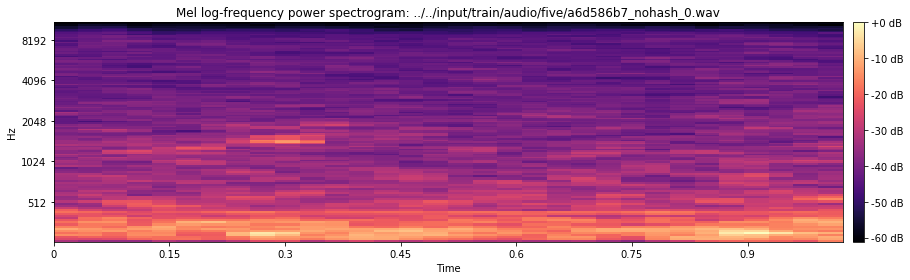

(40, 63)


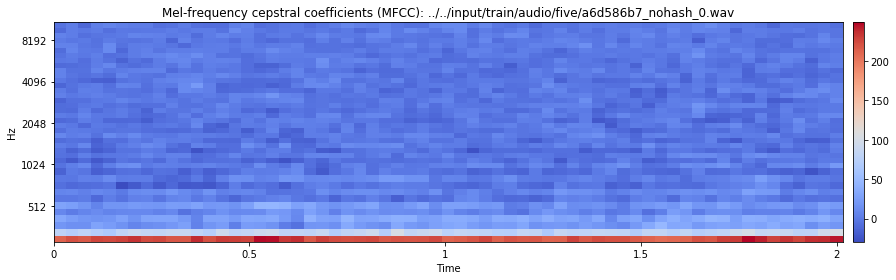

# "seven" [amplitude from -98 to 95, range = 193]

Noise with a "click" heard at full volume


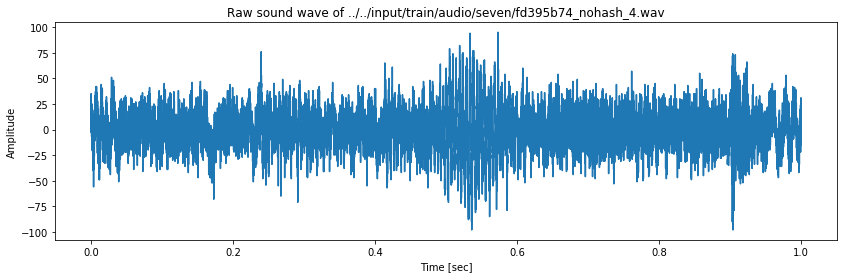

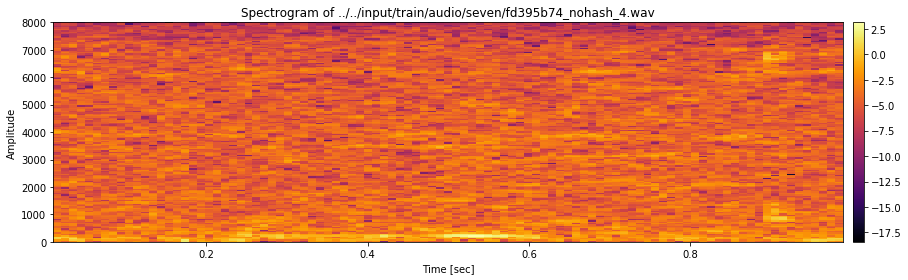

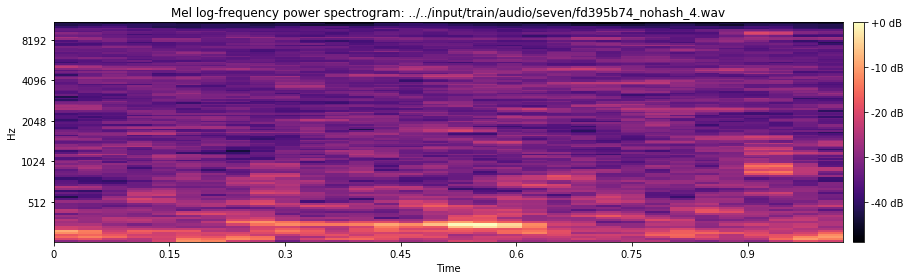

(40, 63)


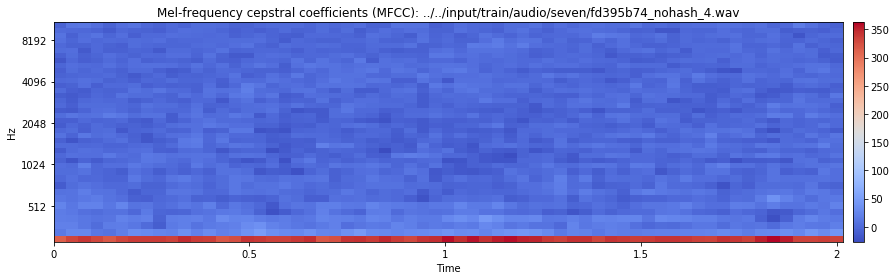

# "zero" [amplitude from -104 to 96, range = 200]

All noise at maximum volume.


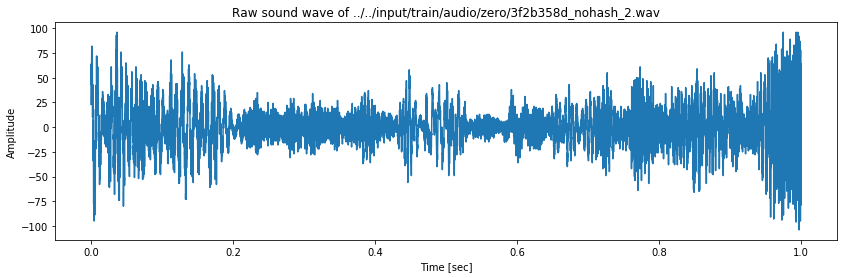

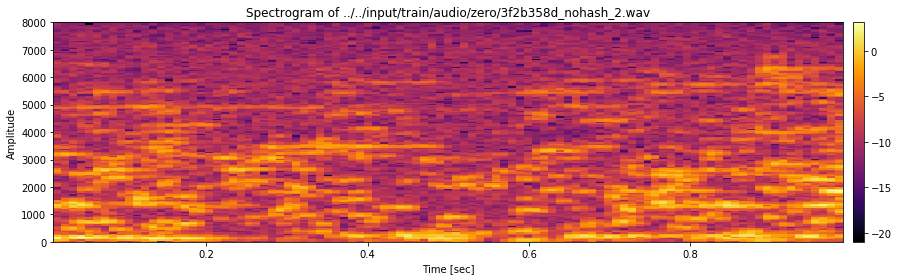

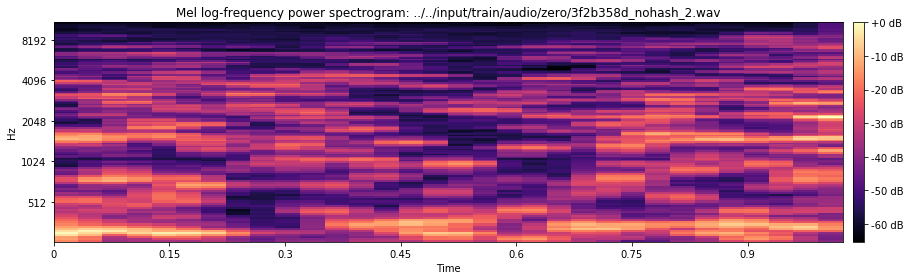

(40, 63)


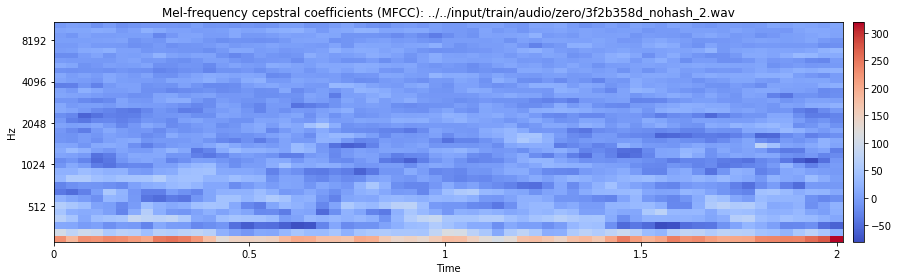

# "eight" [amplitude from -155 to 101, range = 256]

Questionable "eight" identifiable but with a lot of noise at full volume.


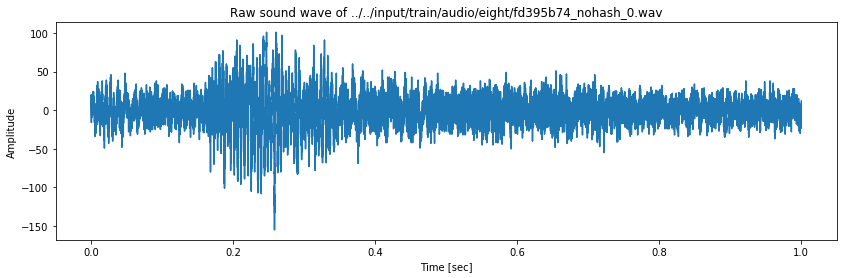

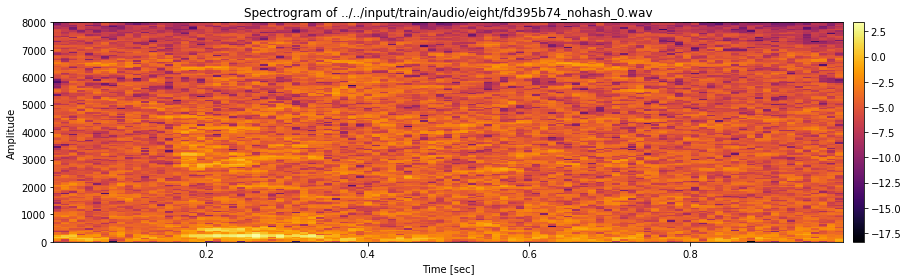

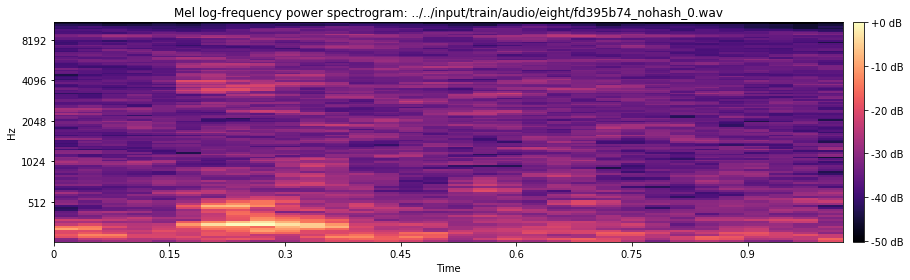

(40, 63)


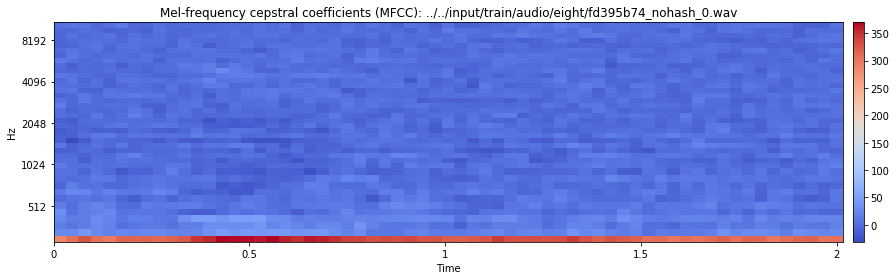

# "zero" [amplitude from -202 to 183, range = 385]

Faint zero with a lot of noise.


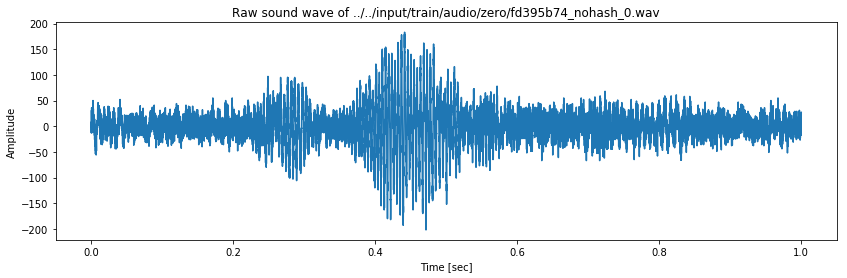

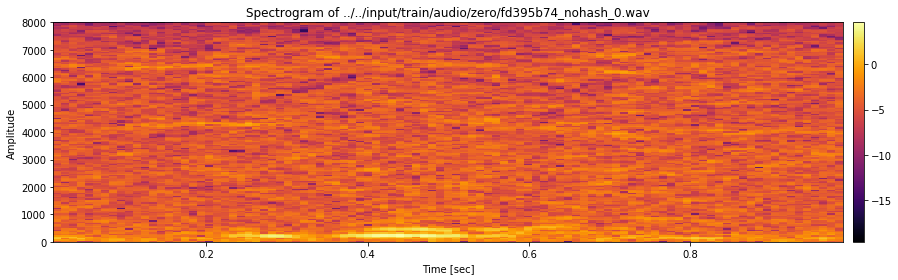

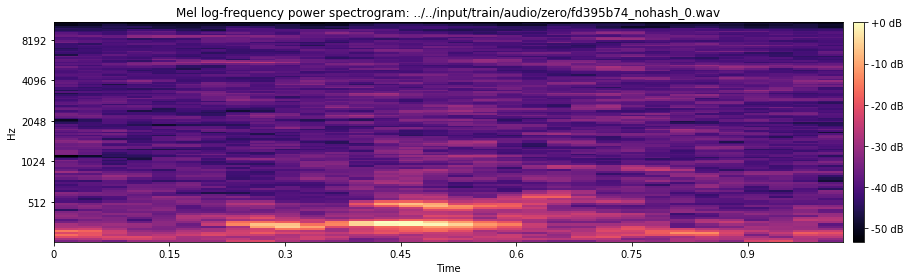

(40, 63)


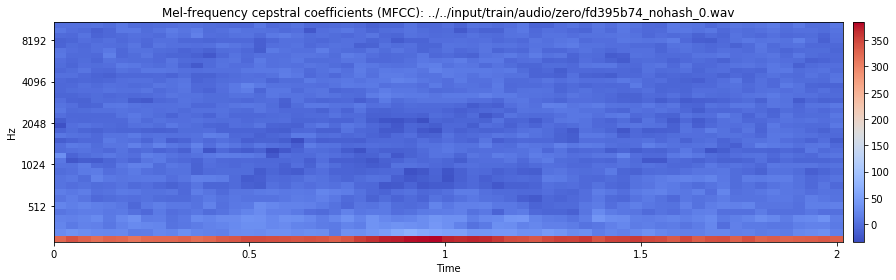

# "two" [amplitude from -276 to 235, range = 511]

Crisp "two" clearly heard at low or high volume. Waveform clearly shows high signal to noise.


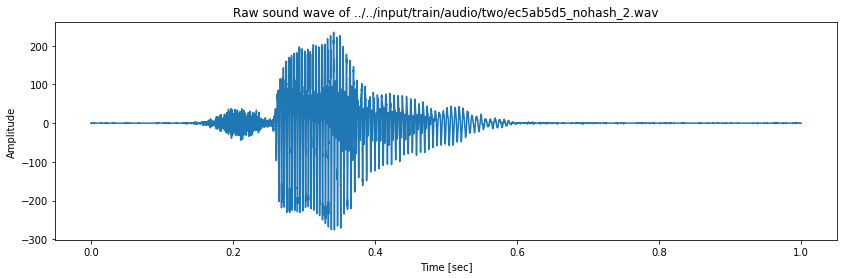

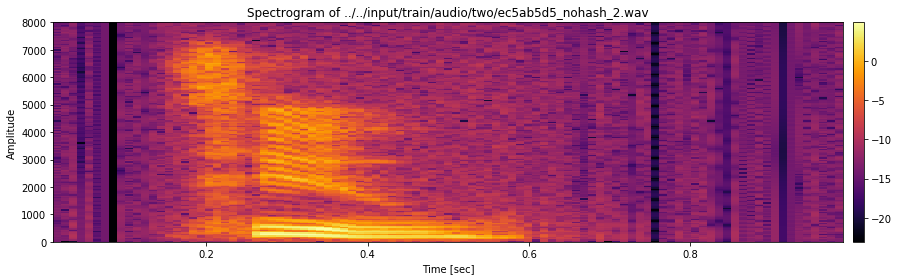

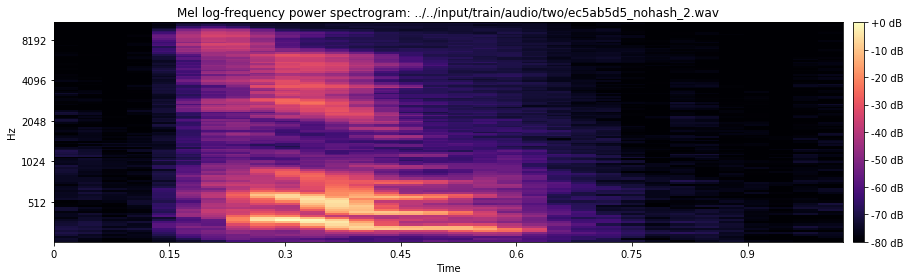

(40, 63)


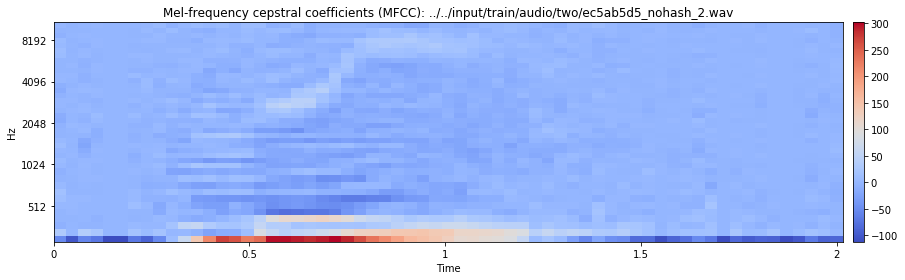

# "three" [amplitude from -546 to 478, range = 1024]

"three" clear at medium to high volume levels, but with some "beeps".


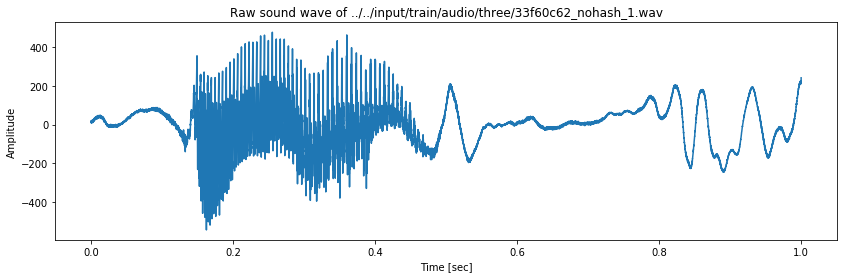

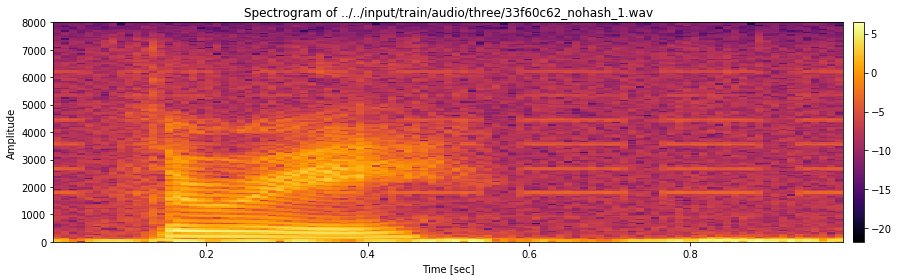

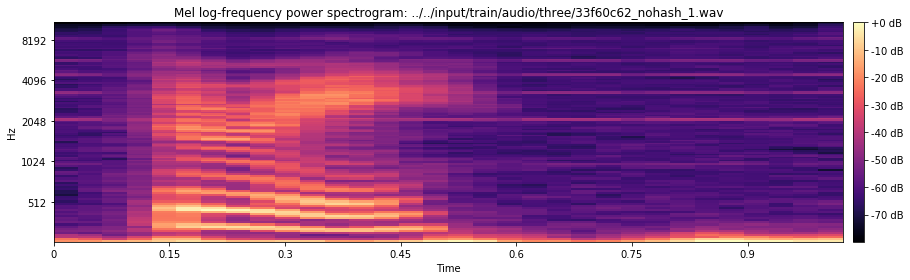

(40, 63)


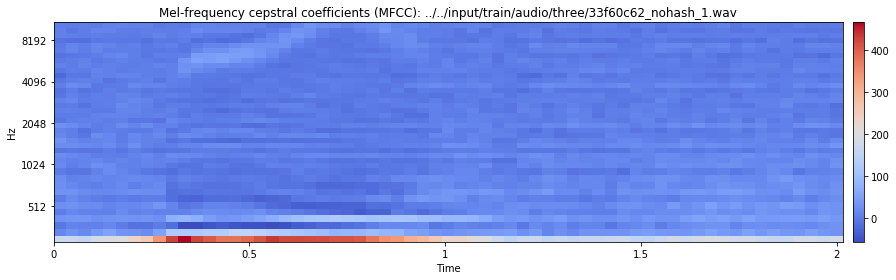

# "zero" [amplitude from -32768 to 32767, range = 65535]

VERY LOUD.  Seems loud even at low volume level.  Note clipping in waveform.


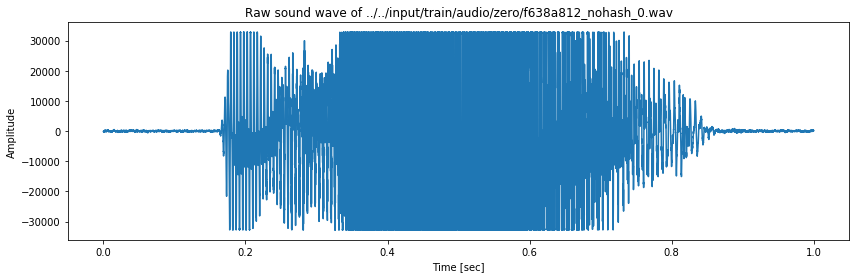

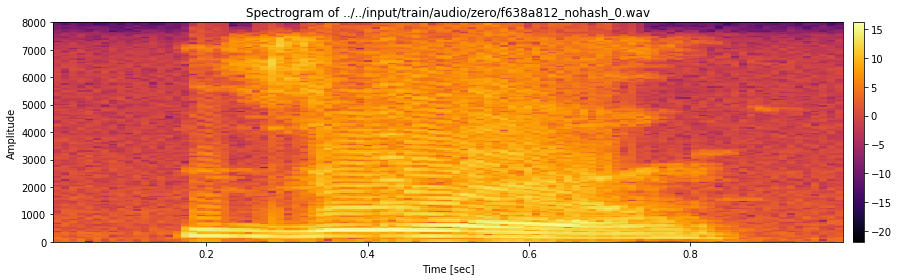

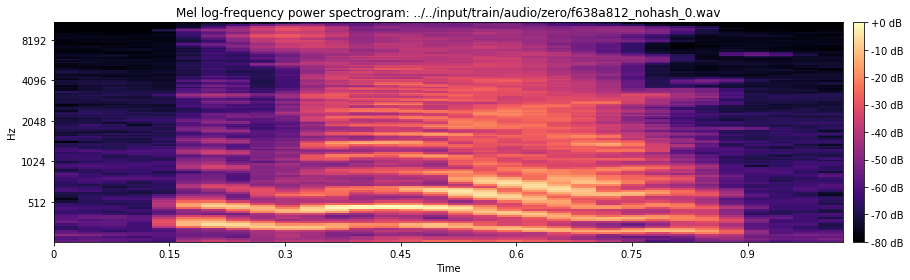

(40, 63)


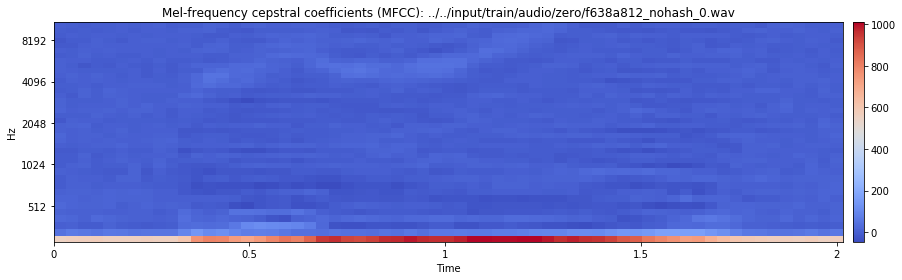

In [15]:
for i in range(wavedf.shape[0]):
    
    filenameShort = wavedf.loc[i, 'filename']
    word, wavename = filenameShort.split("/")
    
    filename = trainAudioPath + filenameShort
    
    sampleRate, samples = wavfile.read(filename)  
    caption = '"' + word  + \
    '" [amplitude from ' + str(min(samples)) +  ' to ' + str(max(samples)) + \
    ', range = ' + str(int(max(samples)) - int(min(samples))) + ']'
    
    printMarkdown("# " + caption)
    print(wavedf.loc[i, 'comments'])
    
    ipd.display( ipd.Audio(filename) )
    sampleRate, samples, logSpectrogram, logMelSpectrogram, mfcc = showWavefile(filename)